<h2>IMPORT SOME LIBRARIES AND READ IN DATA</h2>

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4


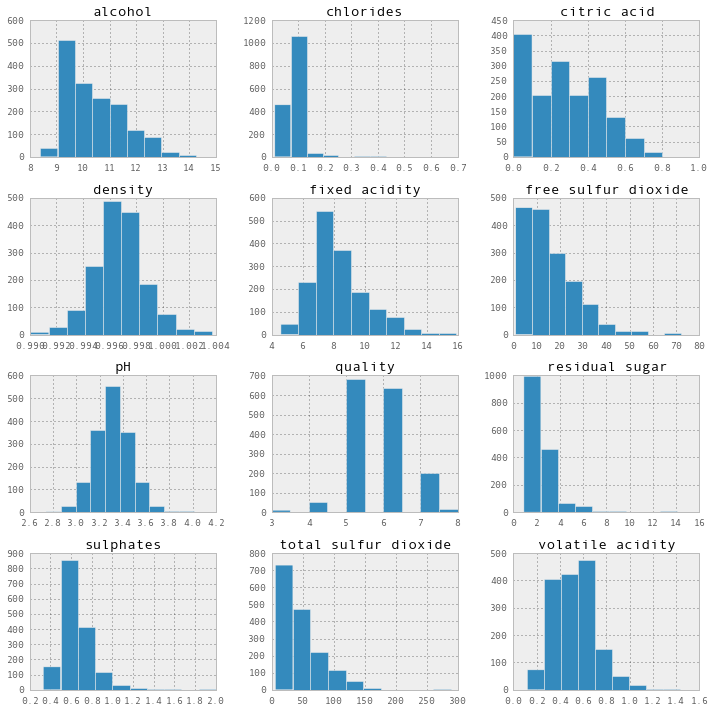

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
##check out tutorial here:
##http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/v0.1/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb
df = pd.read_csv('../winequality-red.csv' , sep = ';')
df1 = df.drop('quality' , 1)
pd.DataFrame.hist(df , figsize=[12,12]);
df1.head() 

<h2>LET'S HAVE A LOOK AT THE PRINCIPAL COMPONENTS</h2>

(1599, 2)


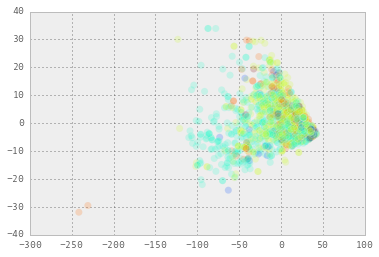

In [7]:
from sklearn.decomposition import PCA #import principal component analysis
pca = PCA(n_components=2) #Instantiate the model & set parameters
pca.fit(df1); #Fit the model
df_pca = pca.transform(df1)#Apply the model. For embeddings / decompositions, this is transform.
print(df_pca.shape)
fig, ax = plt.subplots()
ax.scatter(df_pca[:, 0], df_pca[:, 1] , c = df['quality'] , s = 50 , alpha=0.2);
ax.legend(numpoints=1 , loc='upper left')
plt.show();

[3 4 5 6 7 8]


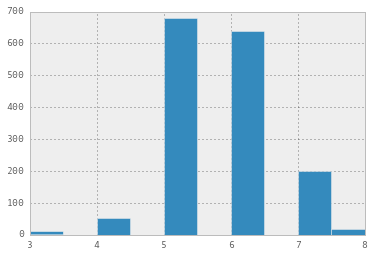

In [3]:
#WE'LL ALSO LOOK AT THE TARGET VARIABLE
target = df['quality'];
plt.hist(target);
print(np.unique(target))

NOTE: THERE IS A SERIOUS CLASS IMBALANCE. RATINGS '3' & '8' HAVE VERY FEW SAMPLES.

In [ ]:
#http://people.ee.duke.edu/~lcarin/ImbalancedClassDistribution.pdf
#'Boosting for Learning Multiple Classes with Imbalanced Class Distribution' and
#http://sci2s.ugr.es/sites/default/files/ficherosPublicaciones/1422_2011-Galar-IEEE_TSMCc-Ensembles.pdf
#'A Review on Ensembles for the Class Imbalance Problem: Bagging-, Boosting-, and Hybrid-Based Approaches'

#try this at some point: (multiclass adaboost)
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html

<h2>IT'S TIME TO DO SOME PREPROCESSING:</h2>

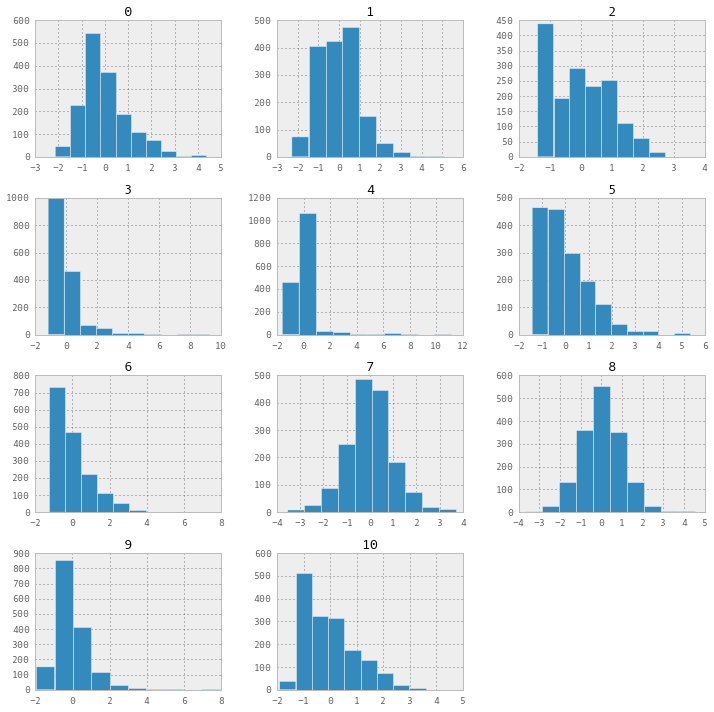

In [8]:
##time to preprocess
from sklearn.preprocessing import scale
df2 = pd.DataFrame( scale(df1) ) #this centers AND scales
#axes = pd.tools.plotting.scatter_matrix(df1, alpha=0.2)
#plt.tight_layout()
#plt.show()
pd.DataFrame.hist(df2 , figsize=[12,12]);

In [10]:
#SPLIT DATA INTO TRAINING & TESTING HERE
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2, df['quality'], test_size = 0.2, 
                                                    random_state=0)
print("X_train shape: %s" % repr(X_train.shape))
print("y_train shape: %s" % repr(y_train.shape))
print("X_test shape: %s" % repr(X_test.shape))
print("y_test shape: %s" % repr(y_test.shape))

X_train shape: (1279, 11)
y_train shape: (1279,)
X_test shape: (320, 11)
y_test shape: (320,)


<h2>NOW TO MACHINE LEARN! FIRST, LET'S TRY A LINEAR SVM WITH K-FOLD CROSS VALIDATION</h2>


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    6.2s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'C': 0.10000000000000001}
0.570758405004


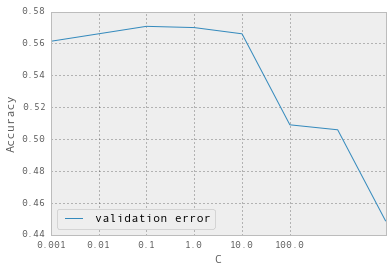

In [12]:
from sklearn.svm import LinearSVC
svm = LinearSVC() # Instantiate the model.
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
#also see here: http://scikit-learn.org/stable/auto_examples/grid_search_digits.html
svm = LinearSVC() # Instantiate the model
tuned_parameters = {'C':10.**np.arange(-3,5)}
grid_search = GridSearchCV( svm , param_grid = tuned_parameters , cv = 5 ,verbose = 1 )
#number of folds must be < than the size of the least populated class
grid_search.fit(X_train, y_train);
print(grid_search.best_params_)
print(grid_search.best_score_)
##see here about the scoring:
##http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
##E.g. gives "accuracy" for SVMs:
##http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
plt.plot([c.mean_validation_score for c in grid_search.grid_scores_], label="validation error")
plt.xticks(np.arange(6), tuned_parameters['C']); plt.xlabel("C"); plt.ylabel("Accuracy");plt.legend(loc='best');
#see this thread concerning mean_training_score:
#http://stackoverflow.com/questions/23389334/how-to-calculate-the-mean-training-score-using-gridsearchcv-in-scikit-learns

that's pretty poor performance!

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.4s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'C': 10.0}
0.608287724785


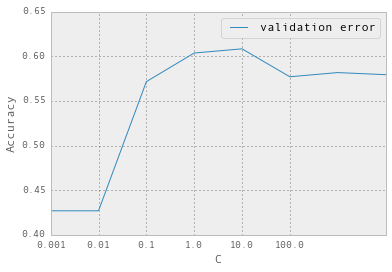

In [14]:
#SO LET'S TRY A GAUSSIAN SVM
from sklearn.svm import SVC
svm1 = SVC(kernel='rbf')# Instantiate the model (SVM w/ Gaussian kernel)
tuned_parameters = {'C':10.**np.arange(-3,5)}
grid_search1 = GridSearchCV( svm1 , param_grid = tuned_parameters , cv = 5 ,verbose = 1 )
grid_search1.fit(X_train, y_train);
print(grid_search1.best_params_)
print(grid_search1.best_score_)
plt.plot([c.mean_validation_score for c in grid_search1.grid_scores_], label="validation error")
plt.xticks(np.arange(6), tuned_parameters['C']); plt.xlabel("C"); plt.ylabel("Accuracy");plt.legend(loc='best');

this is a bit (2%/3%) better than the linear SVM.

<h2>IT'S TIME TO TRY A RANDOM FOREST</h2>

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.1s finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'n_estimators': 80}
0.663799843628


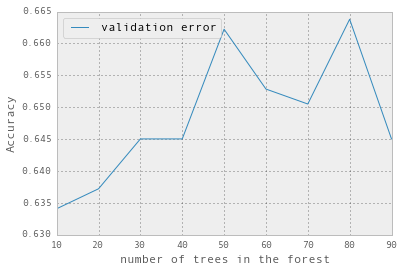

In [17]:
from sklearn.ensemble import RandomForestClassifier
#a random forest builds many randomized decision trees and averages their results.
rf = RandomForestClassifier() #Instantiate the model.
tuned_parameters = {'n_estimators':10*np.arange(1,10)}
grid_search2 = GridSearchCV( rf , param_grid = tuned_parameters , cv = 5 ,verbose = 1 )
grid_search2.fit(X_train, y_train);
print(grid_search2.best_params_)
print(grid_search2.best_score_)
plt.plot([c.mean_validation_score for c in grid_search2.grid_scores_], label="validation error")
plt.xticks(np.arange(9), tuned_parameters['n_estimators']); 
plt.xlabel("number of trees in the forest"); plt.ylabel("Accuracy");plt.legend(loc='best');

ok, this also performs better than the previous two. But it does not seem robust! I.e., there different results each time that you run it. DISCUSS.